In [1]:
%load_ext autoreload 
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os 
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from copy import copy
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from metric_learn import LMNN

from hdbscan import validity_index as DBCV
from hdbscan import HDBSCAN
from clustering_utils import clustering_by_methods,\
                             clustering,\
                             plot_clustering_scatter

from utils import coord_to_pix, entropy
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")
%autoreload 2

# see paper for the thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5
PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0
DATA_PRESERVED_THRESHOLD = 0.9
N_CMAP = 256

# Load data

In [2]:
CPT = 0.01 # minimal percentage of the data in single cluster
DATA_SPECIFICATION =  '' #'_pat0.7'

clustering_results_root = f'results/clustering_cpt-{CPT}{DATA_SPECIFICATION}' 

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

In [3]:
datasets_names = ['AGP', 'HMP']
tax_names = ['o', 'f', 'g']

data_orig = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
    
data_pca = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')
        
try:
    data_embeddings = defaultdict(dict)
    embeddings_indexes = defaultdict(dict)
    embeddings_path = f'./results/embeddings{DATA_SPECIFICATION}'

    for emb_path in glob.glob(embeddings_path + '/*'):
        label_info = emb_path.split('/')[-1].split('.')[0]
        dataset, tax, embedding_type = label_info.split('_')
        d = np.load(emb_path, allow_pickle=True).item()
        label = dataset + '_' + tax
        data_embeddings[embedding_type][label] = d['Z_']
        embeddings_indexes[embedding_type][label] = d['inliers_indexes_mae']
        
except Exception as e:
    print(e)
    pass
    
distance_root = f'distances_processed{DATA_SPECIFICATION}'
distances_names = ['L1', 'L2', 'JS', 'BC']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.96it/s]


# Clustering: precomputed distances

In [4]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [5]:
class SpectralClustering_prec:
    def __init__(self, *args, **kwargs):
        self.method = SpectralClustering(*args, **kwargs, affinity='precomputed', random_state=42)
    def fit_predict(self, X):
        '''
        X - pairwise_distance matrix
        '''
        A = np.exp(-self.method.gamma * np.abs(X))
        return self.method.fit_predict(A)

In [6]:
methods_dict_distances = {
                           'HDBSCAN':[HDBSCAN, 
                              {'min_cluster_size':[5,10,25,50], 
                               'min_samples':[None,5,10,15,20],
                               'metric':['precomputed'],
                               'core_dist_n_jobs':[1],
                               'random_state':[42]}
                               ],
                           'KMedoids':[KMedoids, 
                                       {'n_clusters':np.arange(2, 10, 1),
                                        'method':['pam'],
                                        'metric':['precomputed'],
                                        'init':['k-medoids++'],
                                        'random_state':[42]}],
                           'SpectralClustering':[SpectralClustering_prec, 
                                                 {'n_clusters':np.arange(2, 10, 1), 
                                                  'gamma':[1., 5, 10, 15],
                                                  'eigen_tol':[1e-4]}]
                        }

In [ ]:
for distance_name, distance_dict in tqdm(distances_orig.items()):
    
    results_path = os.path.join(clustering_results_root, f'{distance_name}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    
    distance_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(distance_dict),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict_distances,
                                                                                      precomputed=True,
                                                                                      d=data_orig[label].shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in distance_dict.items())

    # create compatible metrics dicts
    for i,label in enumerate(distance_dict.keys()):
        for j, method_name in enumerate(methods_dict_distances.keys()):
            distance_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, distance_cluster_results)
    
clear_output()

 50%|████████████████████████████████████████████████████████████████                                                                | 2/4 [55:42<56:11, 1685.51s/it]

# Clustering: PCA

In [ ]:
methods_dict = {'HDBSCAN':[HDBSCAN, 
                          {'min_cluster_size':[5,10,25,50], 
                           'min_samples':[None,5,10,15,20],
                           'core_dist_n_jobs':[1]}],
               'KMedoids':[KMedoids, 
                           {'n_clusters':np.arange(2, 10, 1),
                            'method':['pam'],
                            'init':['k-medoids++'],
                            'random_state':[42]}],
               'SpectralClustering':[SpectralClustering, 
                                     {'n_clusters':np.arange(2, 10, 1), 
                                     'affinity':['nearest_neighbors'],
                                     'n_neighbors': [5, 15, 25, 50], 
                                     'eigen_tol':[1e-4],
                                     'random_state':[42]}]}

In [ ]:
results_path = os.path.join(clustering_results_root, f'pca_cluster_results')

pca_cluster_results = defaultdict(dict)

clustering_data_results = Parallel(n_jobs=len(data_pca),
                                   mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                  methods_dict,
                                                                                  precomputed=False,
                                                                                  d=data.shape[1],
                                                                                  cluster_perc_threshold=CPT)
                                                        for label, data in data_pca.items())

# create compatible metrics dicts
for i,label in enumerate(data_pca.keys()):
    for j, method_name in enumerate(methods_dict.keys()):
        pca_cluster_results[label][method_name] = clustering_data_results[i][method_name]

np.save(results_path, pca_cluster_results)

clear_output()

# Clustering selected partitions

In [ ]:
selected_otus_sets = [['g__Bacteroides', 'g__Prevotella', 'g__Ruminococcus']]

data_selected = {}

for selected_otus in selected_otus_sets:

    for label, data in data_orig.items():
        
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{label}.csv', sep=',').drop('Unnamed: 0', axis=1)
        tax_name = label[-1]
        if tax_name == 'g':
            data_selected[label] = dataframe[selected_otus]

In [ ]:
# results_path = os.path.join(clustering_results_root, f'selected_cluster_results')

# selected_cluster_results = defaultdict(dict)

# clustering_data_results = Parallel(n_jobs=len(data_selected),
#                                    mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
#                                                                                   methods_dict,
#                                                                                   precomputed=False,
#                                                                                   d=data.shape[1],
#                                                                                   cluster_perc_threshold=CPT)
#                                                         for label, data in data_selected.items())

# # create compatible metrics dicts
# for i,label in enumerate(data_selected.keys()):
#     for j, method_name in enumerate(methods_dict.keys()):
#         selected_cluster_results[label][method_name] = clustering_data_results[i][method_name]

# np.save(results_path, selected_cluster_results)

# clear_output()

# Clustering: embeddings 

In [ ]:
for embedding_type, embeddings in tqdm(data_embeddings.items()):
    
    results_path = os.path.join(clustering_results_root, f'{embedding_type}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    else:
        print(f'{results_path} exists, calculating...')
    
    embeddings_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(embeddings),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict,
                                                                                      precomputed=False,
                                                                                      d=data.shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in embeddings.items())

    # create compatible metrics dicts
    for i,label in enumerate(embeddings.keys()):
        for j, method_name in enumerate(methods_dict.keys()):
            embeddings_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, embeddings_cluster_results)
    
clear_output()

# Microbiome data

In [7]:
# ['lle', 'L1', 'pca', ...]
representations_names = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

clustering_results_df = []

for representation in representations_names:
    
    clustreing_results_path = os.path.join(clustering_results_root, f'{representation}_cluster_results.npy')
    cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
    # results for each datset
    for label, cl_res_label in cluster_results.items():
        #results for each method given dataset
        for cl_method, cl_res_label_method in cl_res_label.items():
            
            if len(cl_res_label_method) == 0:
                print('Empty results for:', representation, label, cl_method)
                continue
                
            df = pd.DataFrame(cl_res_label_method)

            dataset, tax = label.split('_')
            
            df['dataset'] = dataset
            df['tax'] = tax
            df['representation'] = representation
            df['cl_method'] = cl_method
            # n_clusters found
            n_unique = lambda x: len(np.unique(x[x!=-1]))
            df['n_cl'] = df['labels'].apply(n_unique)
            
            clustering_results_df.append(df)
            
clustering_results_df = pd.concat(clustering_results_df, axis=0, ignore_index=True)

Empty results for: BC AGP_o HDBSCAN
Empty results for: BC AGP_f HDBSCAN
Empty results for: BC AGP_g HDBSCAN
Empty results for: BC HMP_f HDBSCAN
Empty results for: BC HMP_g HDBSCAN
Empty results for: JS AGP_o HDBSCAN
Empty results for: JS AGP_f HDBSCAN
Empty results for: JS AGP_g HDBSCAN
Empty results for: JS HMP_o HDBSCAN
Empty results for: JS HMP_f HDBSCAN
Empty results for: JS HMP_g HDBSCAN
Empty results for: L1 AGP_o HDBSCAN
Empty results for: L1 AGP_f HDBSCAN
Empty results for: L1 AGP_g HDBSCAN
Empty results for: L1 HMP_f HDBSCAN
Empty results for: L1 HMP_g HDBSCAN
Empty results for: L2 AGP_o HDBSCAN
Empty results for: L2 AGP_f HDBSCAN
Empty results for: L2 AGP_g HDBSCAN
Empty results for: L2 HMP_f HDBSCAN
Empty results for: L2 HMP_g HDBSCAN
Empty results for: ae AGP_f HDBSCAN
Empty results for: ae HMP_f HDBSCAN
Empty results for: ae HMP_g HDBSCAN
Empty results for: ae AGP_g HDBSCAN
Empty results for: ae AGP_o HDBSCAN
Empty results for: isomap AGP_f HDBSCAN
Empty results for: isoma

In [8]:
df_mask = (clustering_results_df['data_used'] > DATA_PRESERVED_THRESHOLD) &\
          (clustering_results_df['dbind'] < DBIND_MAX)  &\
          (~clustering_results_df['dbcv'].isna())

clustering_results_df_ = clustering_results_df[df_mask]

In [9]:
clustering_results_df_['cl_method'].value_counts()

SpectralClustering    1862
KMedoids               528
HDBSCAN                 53
Name: cl_method, dtype: int64

# Davies-Bouldin index and Silhoutte score, entropy coloring

In [10]:
nice_repr = {'tsne':'t-SNE',
             'umap':'UMAP',
             'spectral':'SE'}
nice_cl = {'SpectralClustering':'Spectral cl.',
           'HDBSCAN':'HDBSCAN'}

## AGP

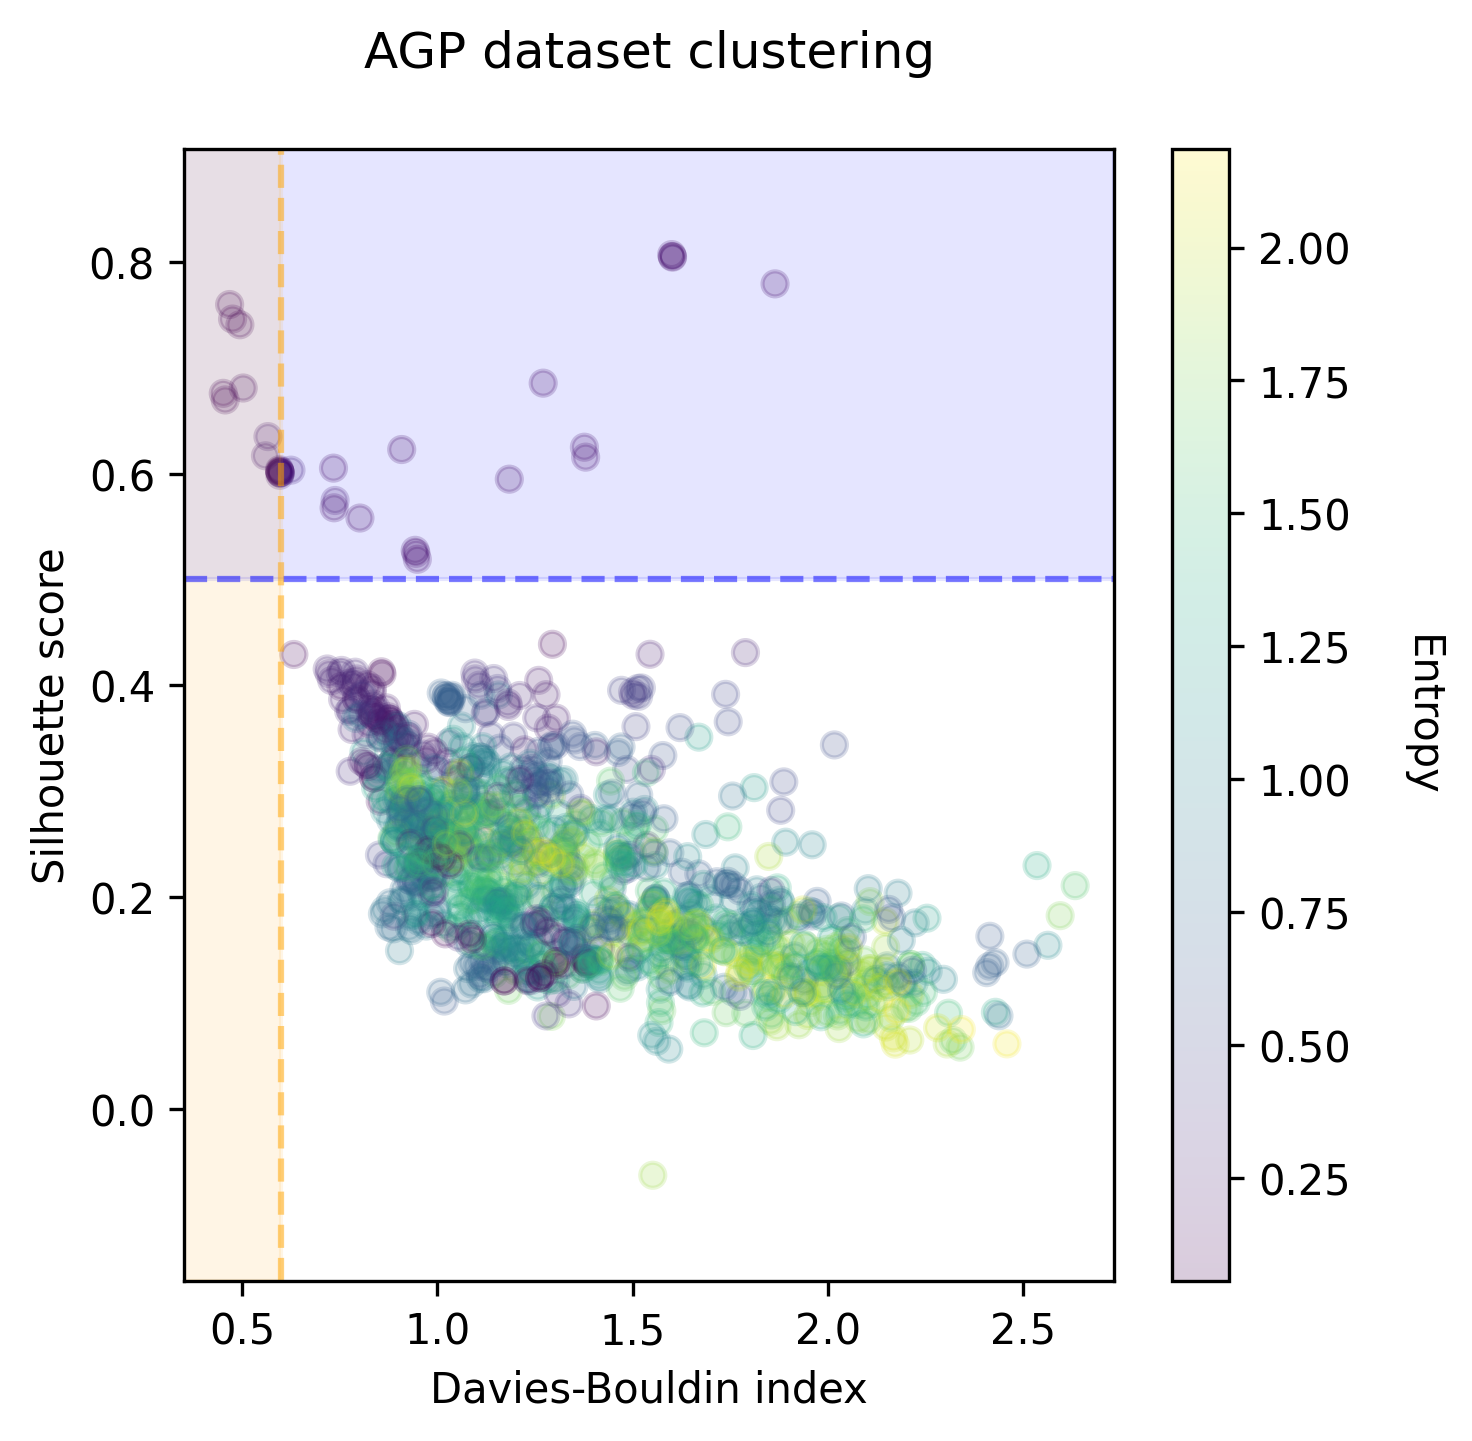

In [11]:
plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

AGP_df = clustering_results_df_.query('dataset == "AGP"')

plot_clustering_scatter(AGP_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='AGP dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [12]:
selection_mask_AGP = (AGP_df['silh'] >= SILHOUETTE_THRESH) * (AGP_df['dbind'] <= DBIND_THRESHOLD)
AGP_df_selected = AGP_df[selection_mask_AGP]

idx = AGP_df_selected['entropy'].idxmax()
best_clustering = AGP_df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

y_AGP_silh = y.copy()
mask_AGP_silh = df_mask.copy()

In [13]:
AGP_df_selected['hash'] = AGP_df_selected[['dataset','tax','representation','cl_method', 'n_cl']].astype(str).sum(1)
idx = AGP_df_selected.groupby('hash')['entropy'].transform(max) == AGP_df_selected['entropy']
AGP_df_selected[idx][['dataset', 'tax', 'representation', 'cl_method', 'n_cl', 'dbind','silh', 'dbcv', 'ps', 'entropy']].round(2)

dataset tax representation           cl_method  n_cl  dbind  silh  dbcv  \
424      AGP   o             L1  SpectralClustering     2   0.60  0.60 -0.63   
1348     AGP   o            lle  SpectralClustering     2   0.49  0.74 -0.86   
1352     AGP   o            lle  SpectralClustering     3   0.60  0.60 -0.91   
1834     AGP   o       spectral  SpectralClustering     2   0.50  0.68 -0.91   
1835     AGP   o       spectral  SpectralClustering     3   0.57  0.63 -0.92   

        ps  entropy  
424   0.28     0.06  
1348  0.75     0.06  
1352  0.51     0.18  
1834  0.39     0.09  
1835  0.55     0.19

In [14]:
X = data_embeddings[X_repr][f'AGP_{X_tax}'][df_mask]
lmnn = PCA(n_components=2)
X = lmnn.fit_transform(X,y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


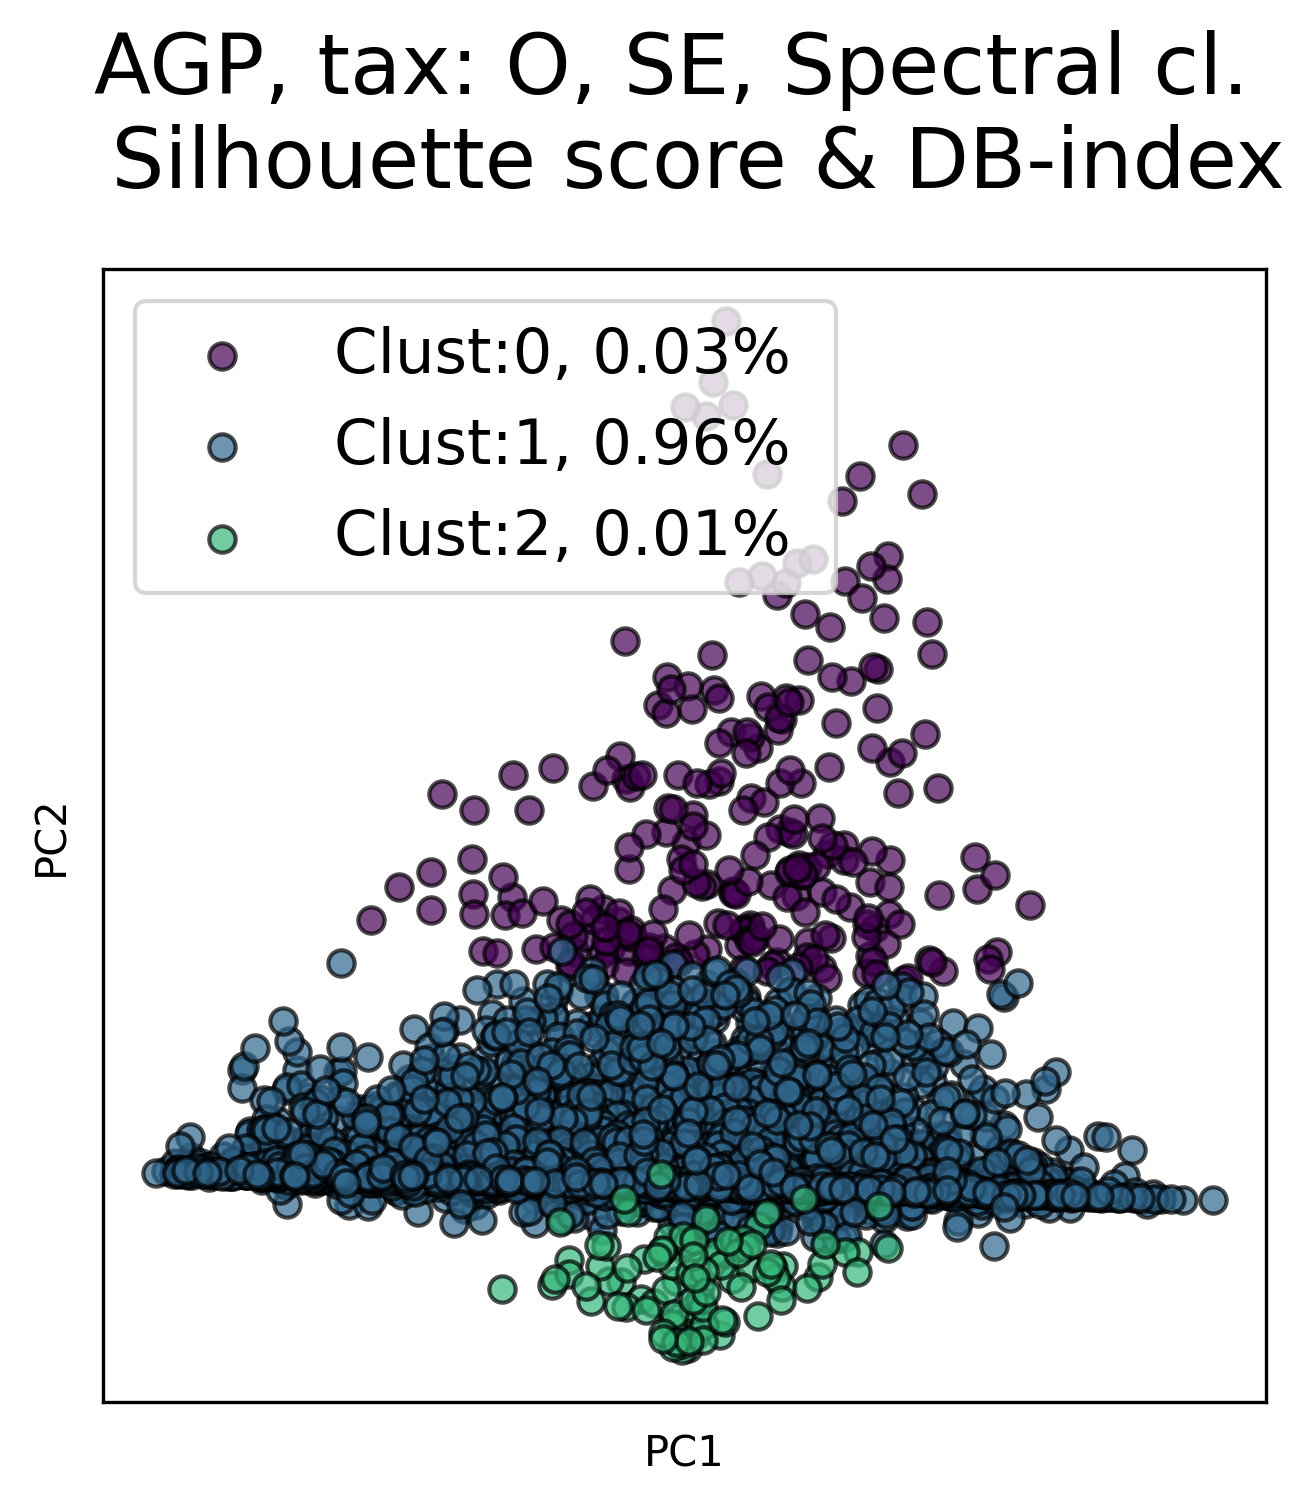

In [15]:
plt.figure(figsize=(5,5), dpi=300)
counter = Counter(y)

# starting from the largest cluster
for i,(y_k, n_k) in enumerate(counter.items()):
    
    if i == len(counter)-1:
        color_index = -1
    if i == 0:
        color_index = 0
    else:
        color_index = int(((i)/len(counter))*N_CMAP)
        
    color_k = plt.colormaps['viridis'].colors[color_index]
    
    perc = np.round(n_k / X.shape[0], 2)
    
    plt.scatter(
                coord_to_pix(X[:,0])[y==y_k], 
                coord_to_pix(X[:,1])[y==y_k],
                c=color_k,
                edgecolors='black',
                s=40,
                alpha=0.7,
                label=f'Clust:{i}, {perc}% '
               )
    
plt.legend(fontsize=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

X_REP = nice_repr[X_repr]
X_CL = nice_cl[X_cl_method]
plt.title(f'AGP, tax: {X_tax.capitalize()}, {X_REP}, {X_CL} \n Silhouette score & DB-index', fontsize=20)
plt.show()

## HMP

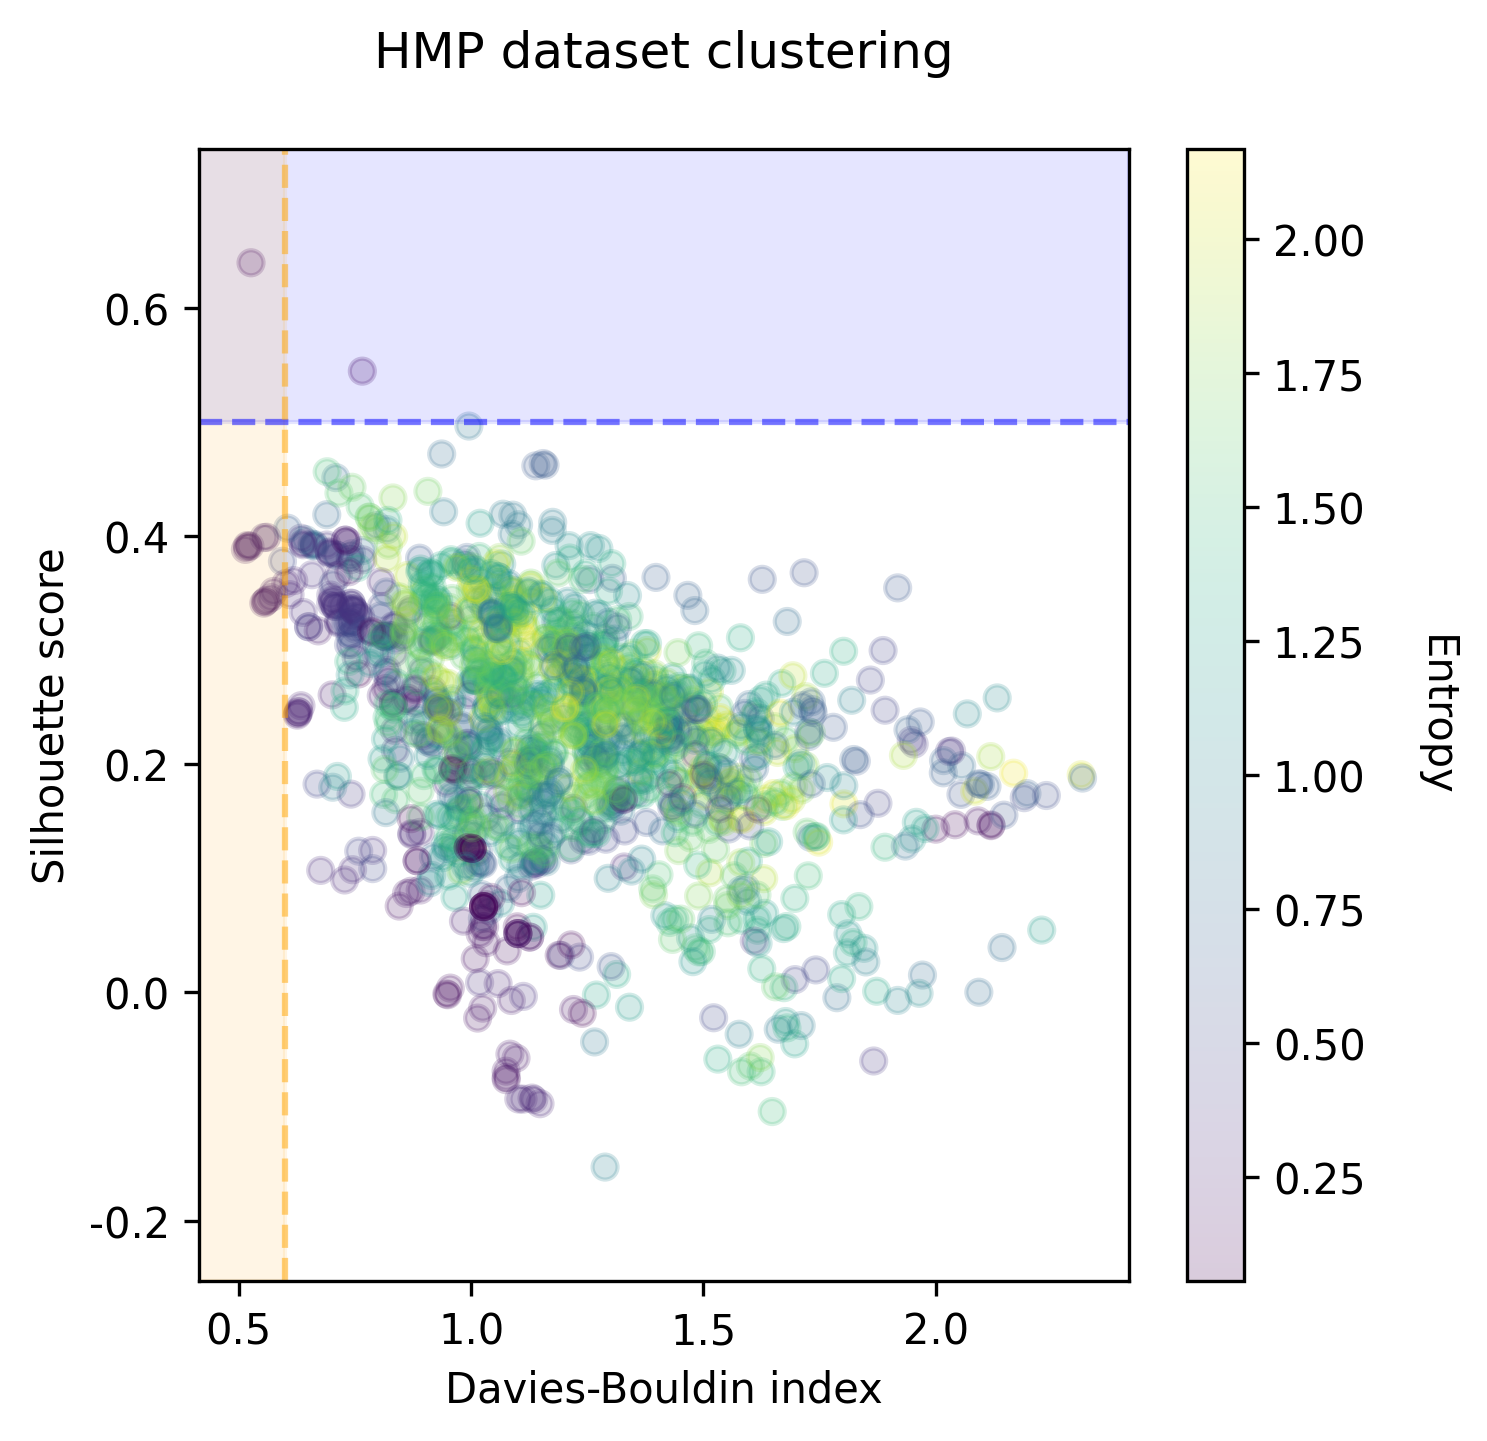

In [16]:
HMP_df = clustering_results_df_.query('dataset == "HMP"')
plot_clustering_scatter(HMP_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='HMP dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

In [17]:
selection_mask_HMP = (HMP_df['silh'] > SILHOUETTE_THRESH) * (HMP_df['dbind'] < DBIND_THRESHOLD)
HMP_df_selected = HMP_df[selection_mask_HMP]

idx = HMP_df_selected['entropy'].idxmax()
best_clustering = HMP_df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']
X = data_embeddings[X_repr][f'HMP_{X_tax}'][df_mask]

y_HMP_silh = y.copy()
mask_HMP_silh = df_mask.copy()

In [18]:
HMP_df_selected['hash'] = HMP_df_selected[['dataset','tax','representation','cl_method','n_cl']].astype(str).sum(1)
idx = HMP_df_selected.groupby('hash')['entropy'].transform(max) == HMP_df_selected['entropy']
HMP_df_selected[idx][['dataset', 'tax', 'representation', 'cl_method', 'n_cl', 'dbind','silh', 'dbcv', 'ps', 'entropy']].round(2)

dataset tax representation cl_method  n_cl  dbind  silh  dbcv    ps  \
1866     HMP   f       spectral   HDBSCAN     2   0.53  0.64 -0.63  0.22   

      entropy  
1866     0.09

In [19]:
lmnn = PCA(n_components=2, random_state=42, whiten=True)
X = lmnn.fit_transform(X,y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


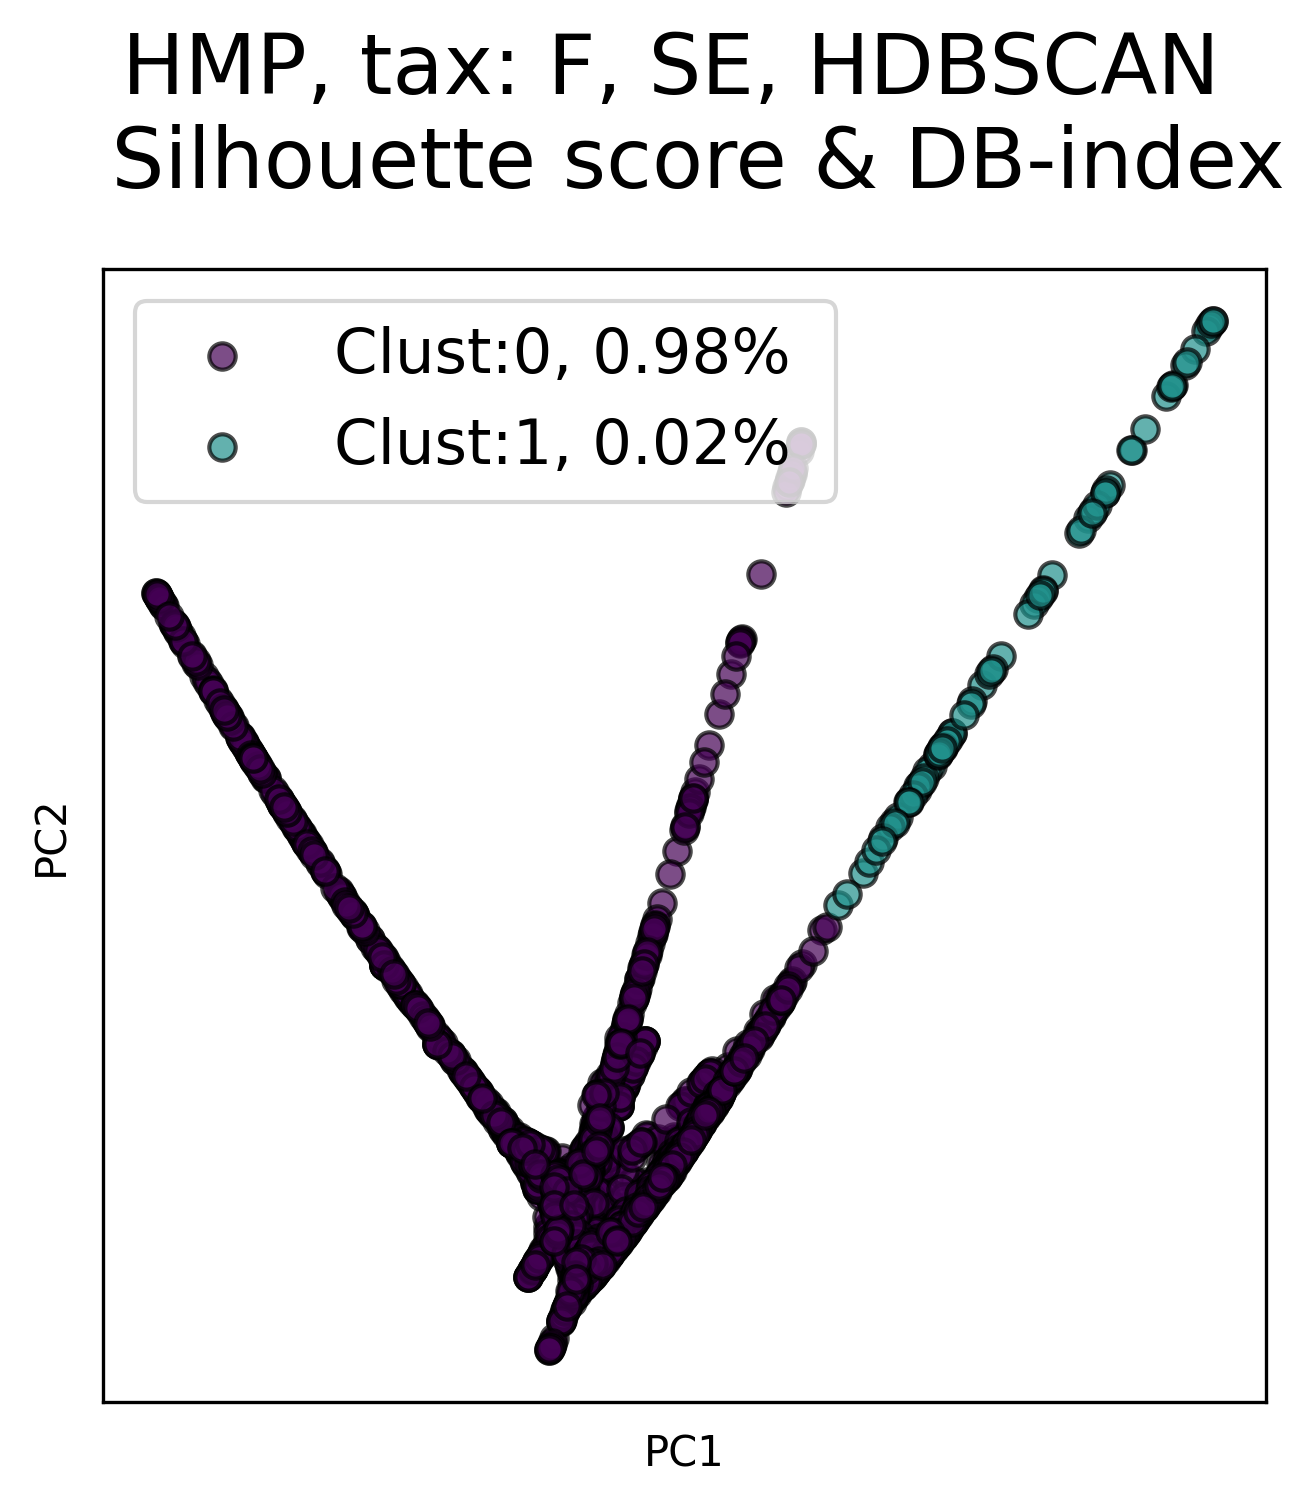

In [20]:
plt.figure(figsize=(5,5), dpi=300)
counter = Counter(y)

# starting from the largest cluster
for i,(y_k, n_k) in enumerate(counter.items()):
    
    if i == len(counter)-1:
        color_index = -1
    if i == 0:
        color_index = 0
    else:
        color_index = int(((i)/len(counter))*N_CMAP)
    
    color_k = plt.colormaps['viridis'].colors[color_index]
    
    perc = np.round(n_k / X.shape[0], 2)
    plt.scatter(
                coord_to_pix(X[:,0])[y==y_k], 
                coord_to_pix(X[:,1])[y==y_k],
                c=color_k,
                edgecolors='black',
                s=40,
                alpha=0.7,
                label=f'Clust:{i}, {perc}% '
               )
    
plt.legend(fontsize=15)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

X_REP = nice_repr[X_repr]
X_CL = nice_cl[X_cl_method]
plt.title(f'HMP, tax: {X_tax.capitalize()}, {X_REP}, {X_CL} \n Silhouette score & DB-index', fontsize=20)
plt.show()

# DBCV and Prediction Score, entropy coloring

## AGP

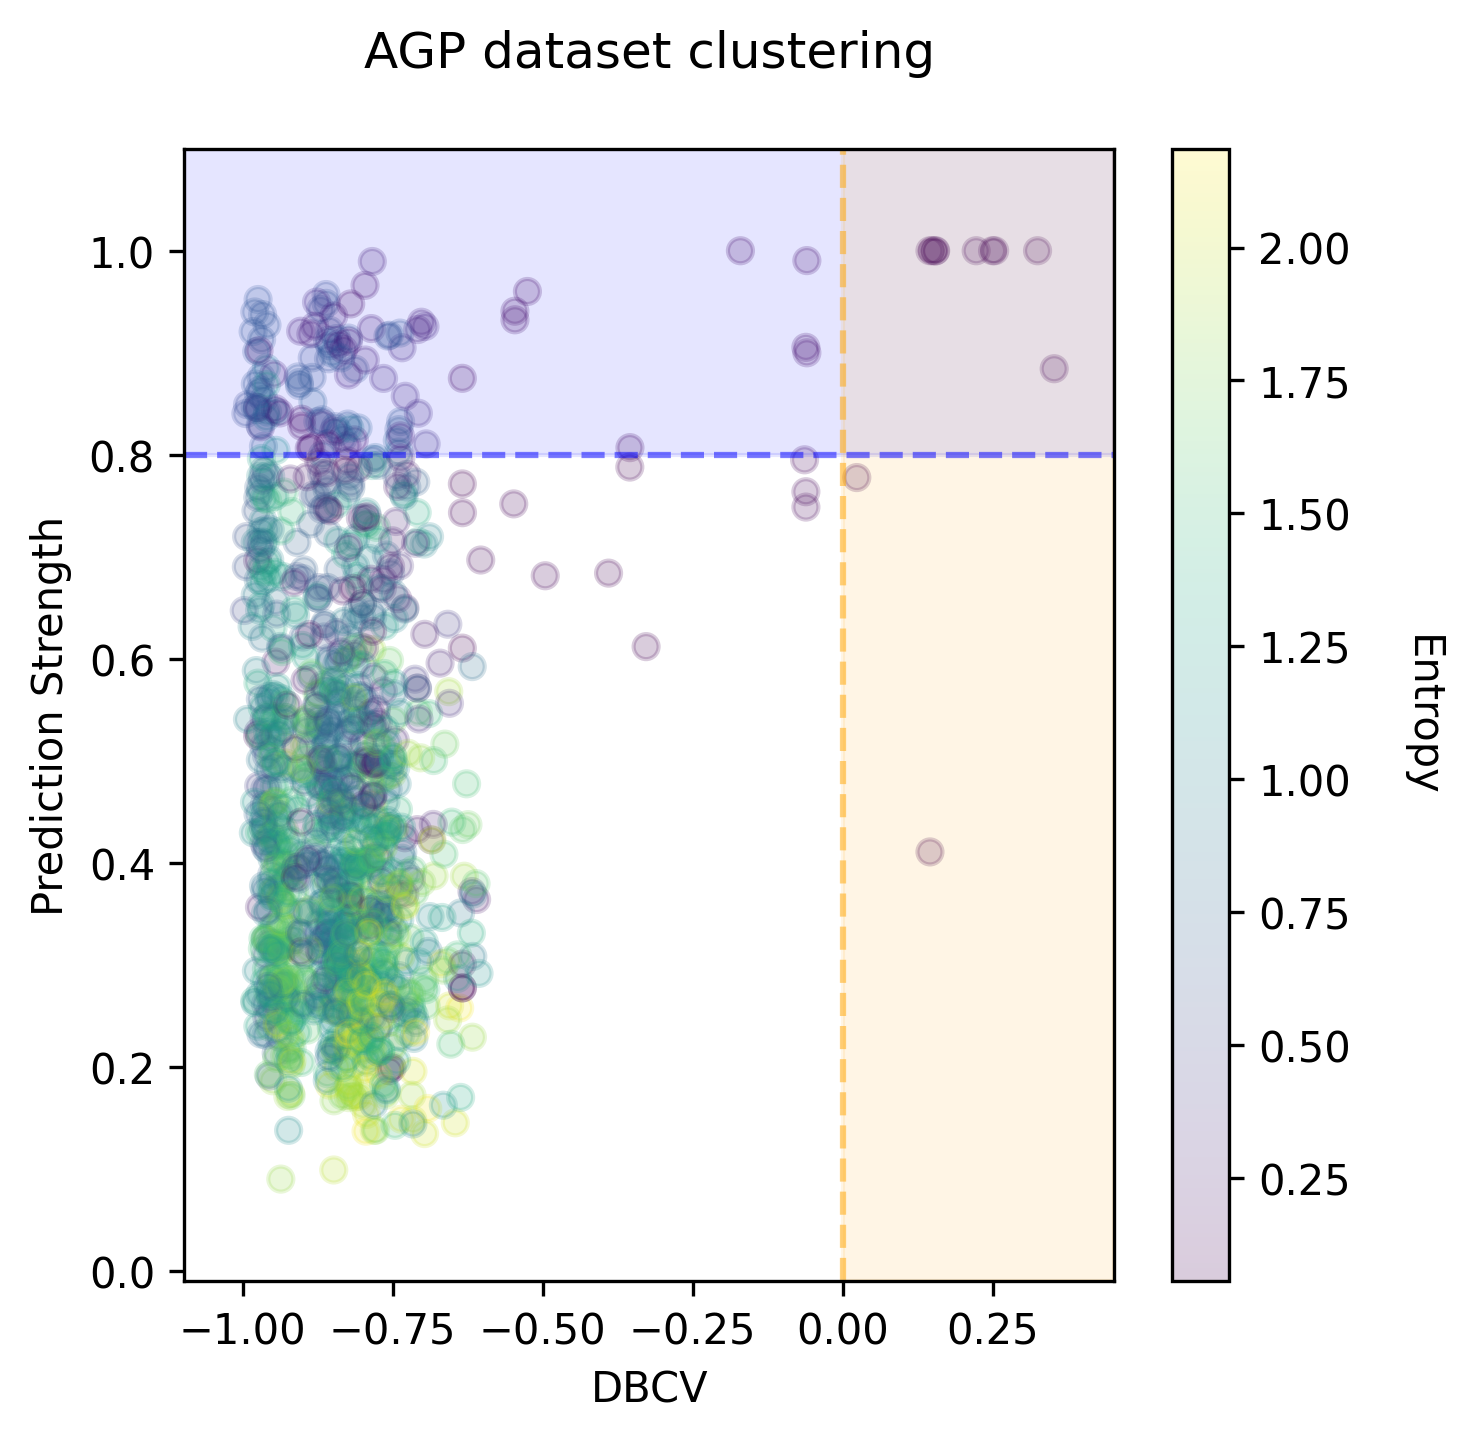

In [21]:
AGP_df = clustering_results_df_.query('dataset == "AGP"')

plot_clustering_scatter(AGP_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='AGP dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [22]:
selection_mask_AGP = (AGP_df['dbcv'] > DBCV_THRESHOLD) * (AGP_df['ps'] > PS_THRESHOLD)
AGP_df_selected = AGP_df[selection_mask_AGP]

idx = AGP_df_selected['entropy'].idxmax()
best_clustering = AGP_df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']
X = data_embeddings[X_repr][f'AGP_{X_tax}'][df_mask]

y_AGP_dbcv = y.copy()
mask_AGP_dbcv = df_mask.copy()

In [23]:
AGP_df_selected['hash'] = AGP_df_selected[['dataset','tax','representation','cl_method','n_cl']].astype(str).sum(1)
idx = AGP_df_selected.groupby('hash')['entropy'].transform(max) == AGP_df_selected['entropy']
AGP_df_selected[idx][['dataset', 'tax', 'representation', 'cl_method', 'n_cl', 'dbind','silh', 'dbcv', 'ps', 'entropy']].round(2)

dataset tax representation cl_method  n_cl  dbind  silh  dbcv   ps  \
2195     AGP   f           tsne   HDBSCAN     2   1.38  0.14  0.15  1.0   
2367     AGP   f           umap   HDBSCAN     2   1.02  0.17  0.22  1.0   
2509     AGP   g           umap   HDBSCAN     2   1.03  0.23  0.25  1.0   

      entropy  
2195     0.09  
2367     0.06  
2509     0.08

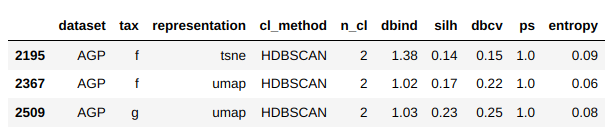

In [24]:
lmnn = LMNN(n_components=2, 
            max_iter=500, 
            learn_rate=1e-4, 
            convergence_tol=1e-2, 
            random_state=42, 
            k=25, 
            verbose=False)


X = lmnn.fit_transform(X,y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


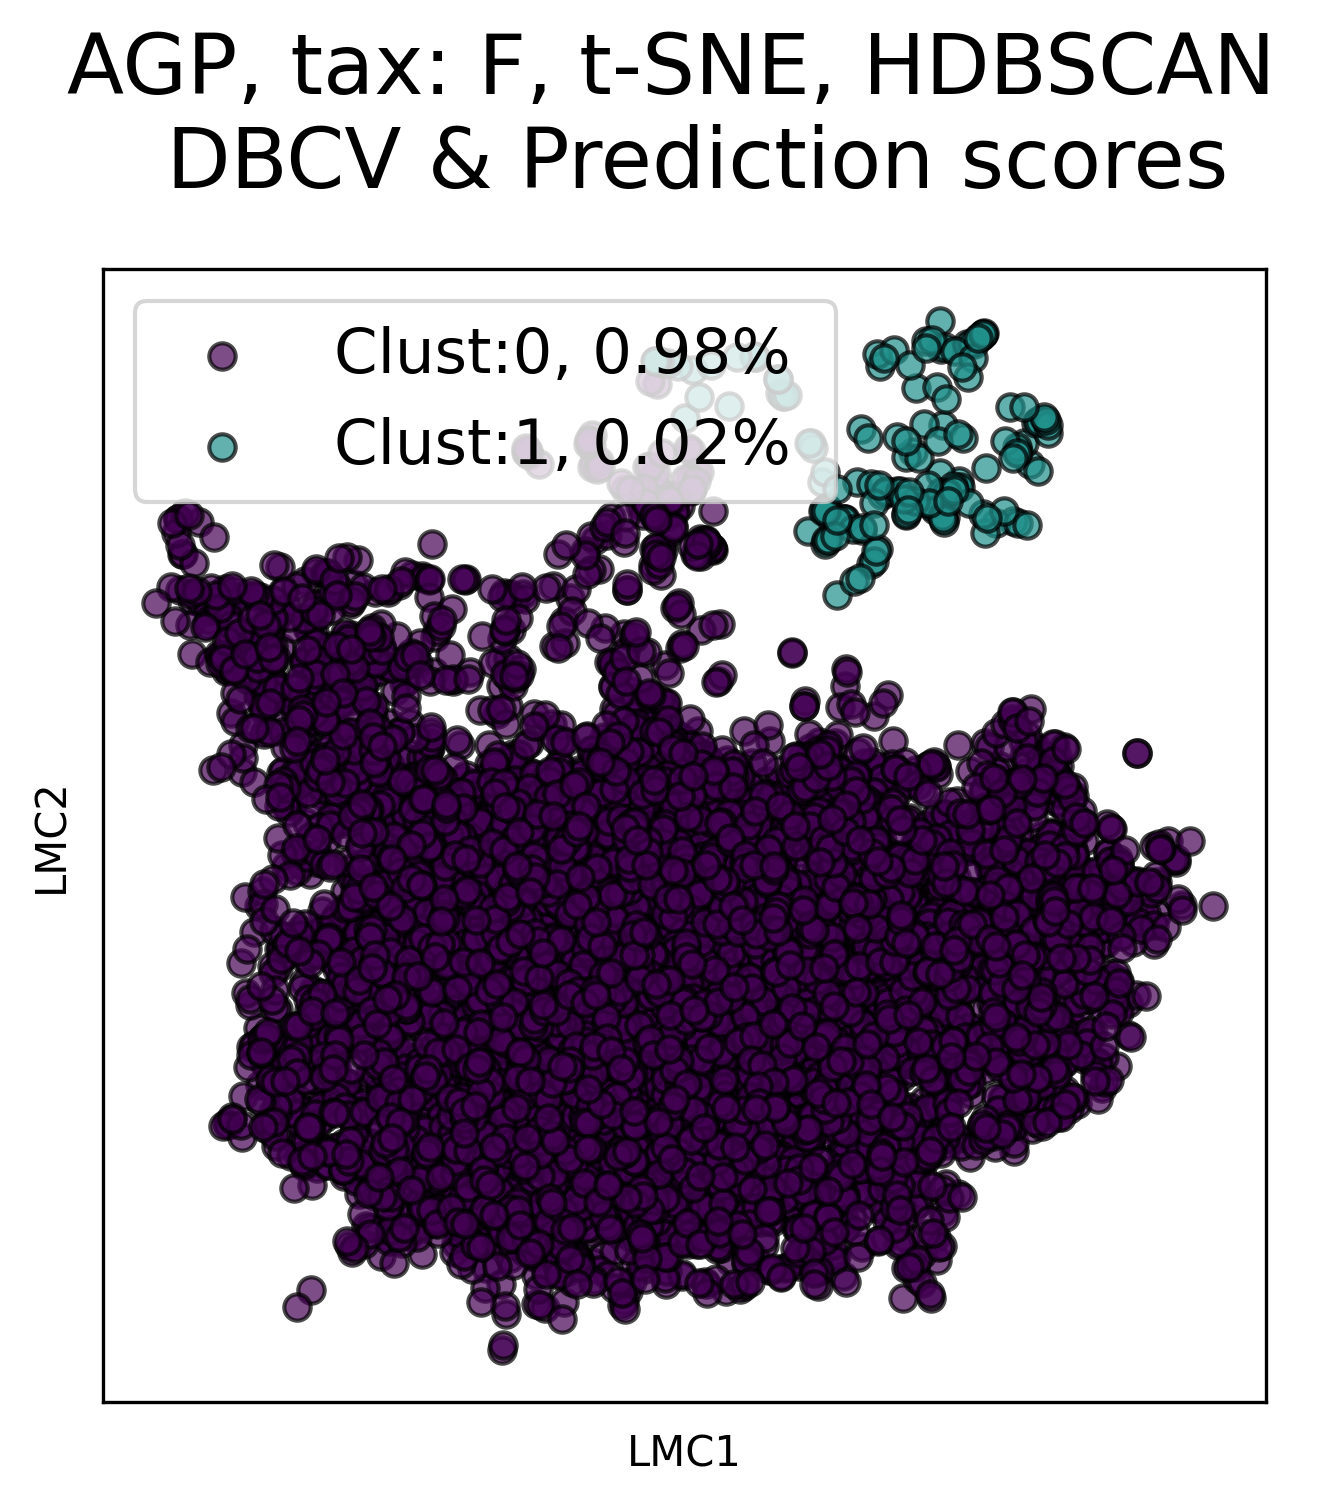

In [25]:
plt.figure(figsize=(5,5), dpi=300)
counter = Counter(y)

# starting from the largest cluster
for i,(y_k, n_k) in enumerate(counter.items()):
    
    if i == len(counter)-1:
        color_index = -1
    if i == 0:
        color_index = 0
    else:
        color_index = int(((i)/len(counter))*N_CMAP)
  
    color_k = plt.colormaps['viridis'].colors[color_index]
    
    perc = np.round(n_k / X.shape[0], 2)
    plt.scatter(
                coord_to_pix(X[:,0])[y==y_k], 
                coord_to_pix(X[:,1])[y==y_k],
                c=color_k,
                edgecolors='black',
                s=40,
                alpha=0.7,
                label=f'Clust:{i}, {perc}% '
               )
plt.legend(fontsize=15)
plt.xlabel('LMC1')
plt.ylabel('LMC2')
plt.xticks([])
plt.yticks([])

X_REP = nice_repr[X_repr]
X_CL = nice_cl[X_cl_method]
plt.title(f'AGP, tax: {X_tax.capitalize()}, {X_REP}, {X_CL} \n DBCV & Prediction scores', fontsize=20)
plt.show()

## HMP

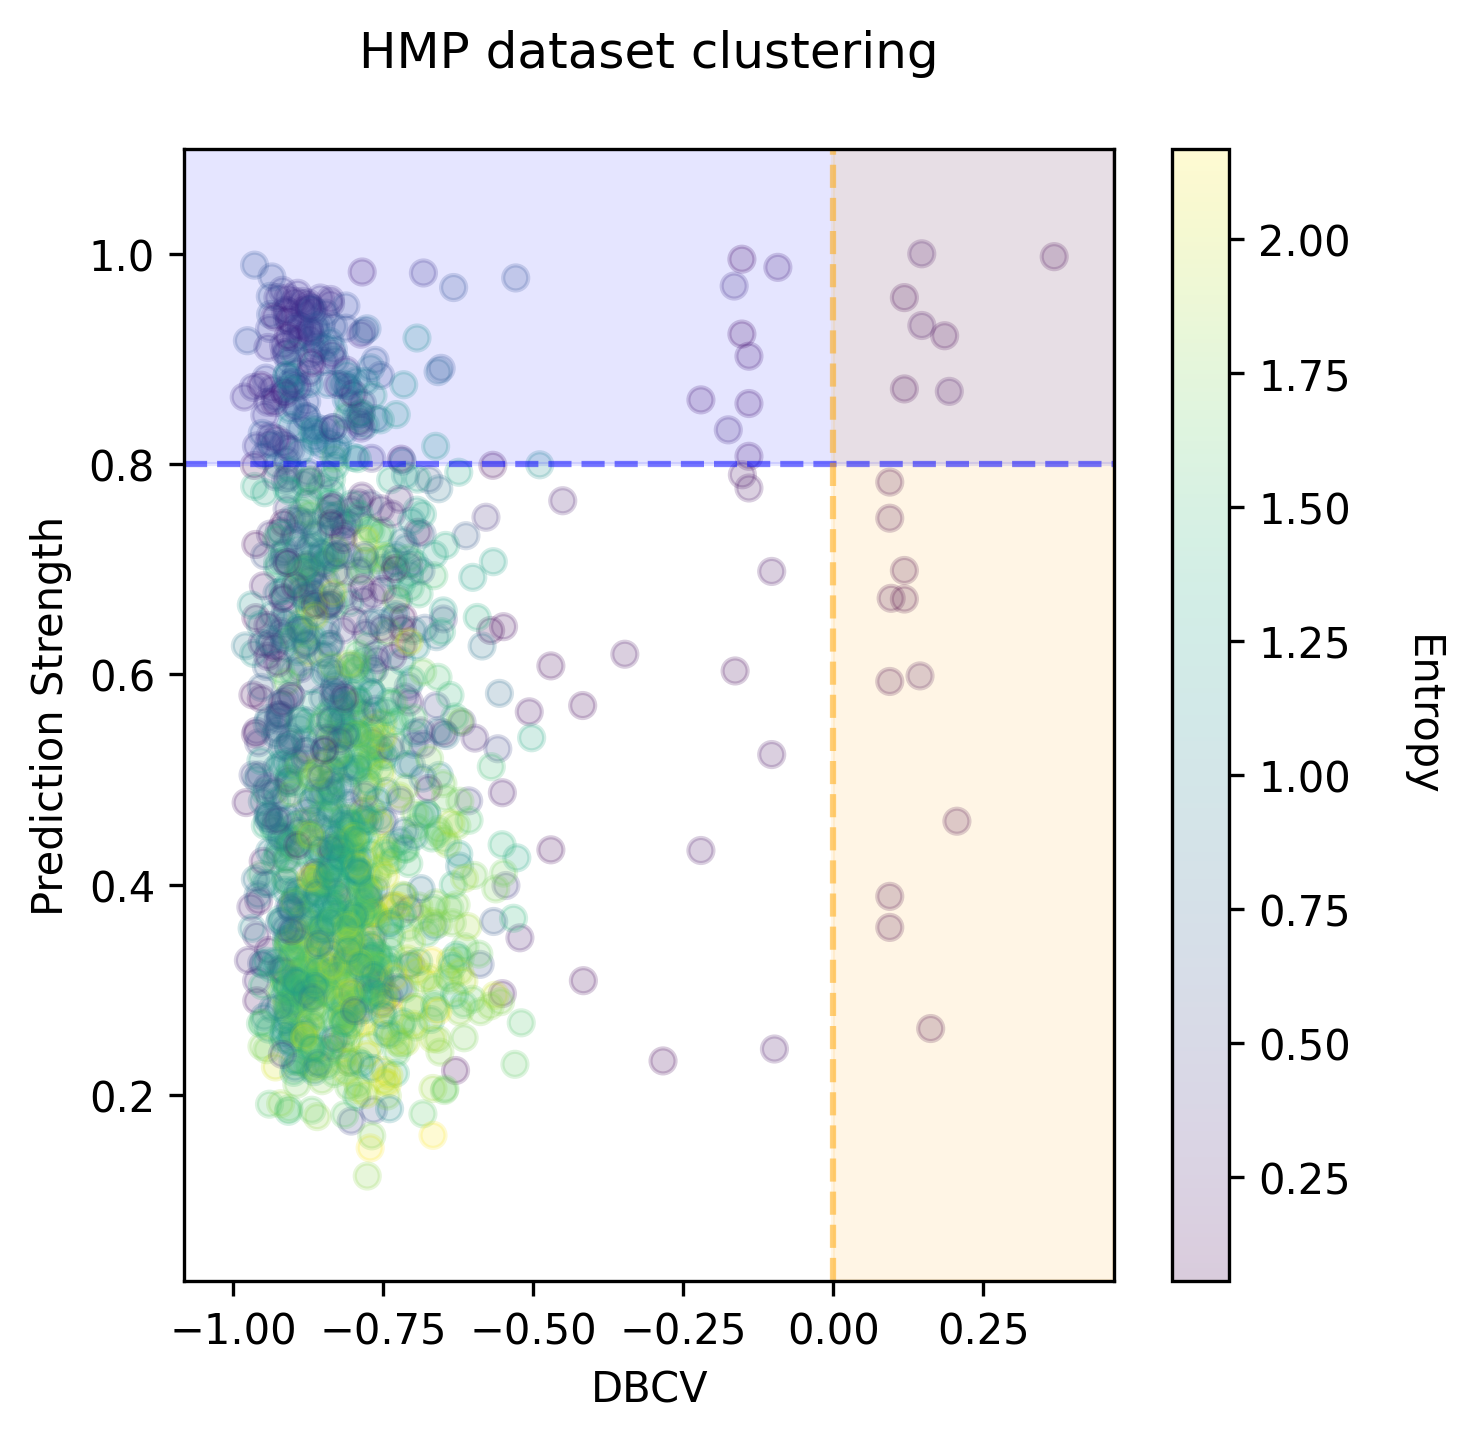

In [26]:
HMP_df = clustering_results_df_.query('dataset == "HMP"')
plot_clustering_scatter(HMP_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='HMP dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

In [27]:
selection_mask_HMP = (HMP_df['dbcv'] > DBCV_THRESHOLD) * (HMP_df['ps'] > PS_THRESHOLD)
HMP_df_selected = HMP_df[selection_mask_HMP]

idx = HMP_df_selected['entropy'].idxmax()
best_clustering = HMP_df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_embeddings[X_repr][f'HMP_{X_tax}'][df_mask]

y_HMP_dbcv = y.copy()
mask_HMP_dbcv = df_mask.copy()


In [28]:
HMP_df_selected['hash'] = HMP_df_selected[['dataset','tax','representation','cl_method','n_cl']].astype(str).sum(1)
idx = HMP_df_selected.groupby('hash')['entropy'].transform(max) == HMP_df_selected['entropy']
HMP_df_selected[idx][['dataset', 'tax', 'representation', 'cl_method', 'n_cl', 'dbind','silh', 'dbcv', 'ps', 'entropy']].round(2)

dataset tax representation cl_method  n_cl  dbind  silh  dbcv    ps  \
2240     HMP   o           tsne   HDBSCAN     2   1.00  0.13  0.12  0.96   
2242     HMP   o           tsne   HDBSCAN     2   1.00  0.13  0.12  0.87   
2555     HMP   o           umap   HDBSCAN     2   0.87  0.15  0.19  0.92   
2560     HMP   o           umap   HDBSCAN     3   1.02  0.06  0.19  0.87   

      entropy  
2240     0.06  
2242     0.06  
2555     0.08  
2560     0.16

In [29]:
lmnn = LMNN(n_components=2, 
            max_iter=1000, 
            learn_rate=1e-3, 
            convergence_tol=1e-2, 
            random_state=42, 
            k=25, 
            verbose=False)

X = lmnn.fit_transform(X,y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


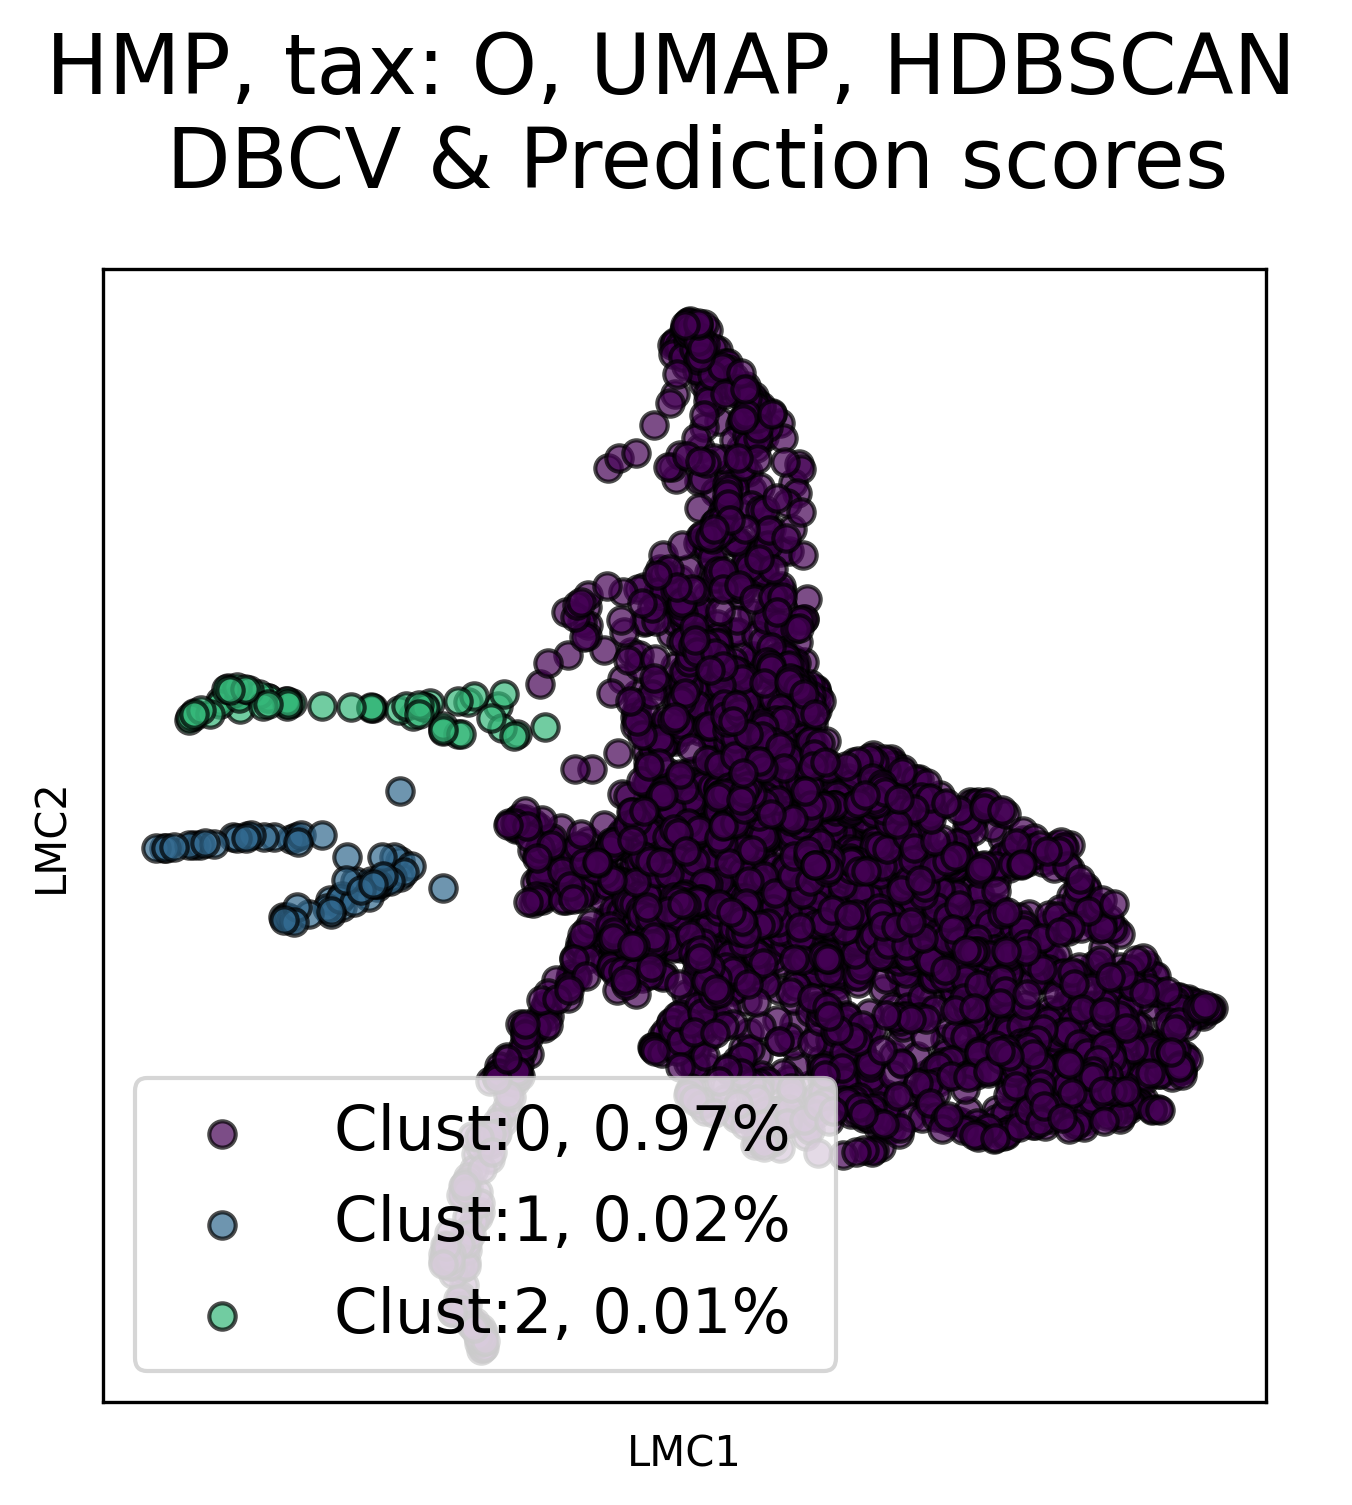

In [30]:
plt.figure(figsize=(5,5), dpi=300)
counter = Counter(y)

# starting from the largest cluster
for i,(y_k, n_k) in enumerate(counter.items()):
    
    if i == len(counter)-1:
        color_index = -1
    if i == 0:
        color_index = 0
    else:
        color_index = int(((i)/len(counter))*N_CMAP)
        
    color_k = plt.colormaps['viridis'].colors[color_index]
    
    perc = np.round(n_k / X.shape[0], 2)
    plt.scatter(
                coord_to_pix(X[:,0])[y==y_k], 
                coord_to_pix(X[:,1])[y==y_k],
                c=color_k,
                edgecolors='black',
                s=40,
                alpha=0.7,
                label=f'Clust:{i}, {perc}% '
               )
plt.legend(fontsize=15)
plt.xlabel('LMC1')
plt.ylabel('LMC2')
plt.xticks([])
plt.yticks([])
X_REP = nice_repr[X_repr]
X_CL = nice_cl[X_cl_method]

plt.title(f'HMP, tax: {X_tax.capitalize()}, {X_REP}, {X_CL} \n DBCV & Prediction scores', fontsize=20)
plt.show()

# Intersection of the different clustering partitions

In [31]:
preprocessing_mask = np.load('./data_processed/preprocessing_mask.npy', allow_pickle=True).item()

In [32]:
for k,v in preprocessing_mask.items():
    print(k,v.shape, v.sum())

AGP_o (9511,) 9511
AGP_f (9511,) 9511
AGP_g (9511,) 9511
HMP_o (4587,) 4558
HMP_f (4587,) 4564
HMP_g (4587,) 4563


In [33]:
# take mask of the remaining elements from the preprocessing
HMP_F_mask = preprocessing_mask['HMP_f']
y_HMP_silh_mask = np.zeros_like(HMP_F_mask, dtype=bool)
y_HMP_silh_ind = np.arange(HMP_F_mask.shape[0])
# indexes of the remaining elements after making an embeddings on preprocessed data
y_HMP_silh_emb_ind = embeddings_indexes['spectral']['HMP_f']
# select only the indexes of the original dataset remained after prepocessing, embedding and clustering 
y_HMP_silh_ind = y_HMP_silh_ind[HMP_F_mask][y_HMP_silh_emb_ind][mask_HMP_silh]
y_HMP_silh_mask[y_HMP_silh_ind] = True

# repeat the same for another found partition
HMP_O_mask = preprocessing_mask['HMP_o']
y_HMP_dbcv_emb_ind = embeddings_indexes['umap']['HMP_o']
y_HMP_dbcv_mask = np.zeros_like(HMP_O_mask, dtype=bool)
y_HMP_dbcv_ind = np.arange(HMP_O_mask.shape[0])
y_HMP_dbcv_ind = y_HMP_dbcv_ind[HMP_O_mask][y_HMP_dbcv_emb_ind][mask_HMP_dbcv]
y_HMP_dbcv_mask[y_HMP_dbcv_ind] = True


y_HMP_mask = y_HMP_silh_mask*y_HMP_dbcv_mask
# create extended labels with -1 padding
y_HMP_silh_ = -1*np.ones_like(y_HMP_mask)
y_HMP_silh_[y_HMP_silh_mask] = y_HMP_silh

y_HMP_dbcv_ = -1*np.ones_like(y_HMP_mask) 
y_HMP_dbcv_[y_HMP_dbcv_mask] = y_HMP_dbcv


ars_HMP = adjusted_rand_score(y_HMP_silh_[y_HMP_mask], 
                              y_HMP_dbcv_[y_HMP_mask])

print('Adjusted Rand Score for HMP results',ars_HMP)

Adjusted Rand Score for HMP results -0.023929499306482496


In [34]:
# it is a bit simpler for AGP, since all samples are remained after preprocessing
y_AGP_dbcv_ = np.empty_like(mask_AGP_dbcv)
y_AGP_dbcv_[mask_AGP_dbcv] = y_AGP_dbcv
y_AGP_silh_ = np.empty_like(mask_AGP_silh)
y_AGP_silh_[mask_AGP_silh] = y_AGP_silh

mask_AGP_dbcvsilh = mask_AGP_dbcv*mask_AGP_silh
ars_AGP = adjusted_rand_score(y_AGP_silh_[mask_AGP_dbcvsilh], 
                              y_AGP_dbcv_[mask_AGP_dbcvsilh])

print('Adjusted Rand Score for AGP results',ars_AGP)

Adjusted Rand Score for AGP results 0.007021978083639407
